In [10]:
# Importing the Base Libraries

import numpy as np
from numpy import array
import pandas as pd
import re
import nltk
import spacy
import gensim
import logging

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('..') # Current Directory
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Importing the Dataset
df = pd.read_json('/content/drive/My Drive/Projects/Introduction to Topic Modeling for Business/News_Category_Dataset_v2.json', lines=True).reset_index()

In [12]:
# Validating the Data

df.head().append(df.tail())

,index,category,headline,authors,link,short_description,date
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
200848,200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28
200852,200852,SPORTS,Dwight Howard Rips Teammates After Magic Loss ...,,https://www.huffingtonpost.com/entry/dwight-ho...,The five-time all-star center tore into his te...,2012-01-28


In [13]:
# Get the Category

df['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [14]:
# Get Certain categories only from the DataFrame

get_cat = ['WOMEN', 'MONEY', 'SCIENCE', 'RELIGION', 'MEDIA', 'CRIME', 'IMPACT']

df2 = df[ (df['category'].isin(get_cat)) ]

In [15]:
len(df2)

df2 = df2.reset_index(drop= True)

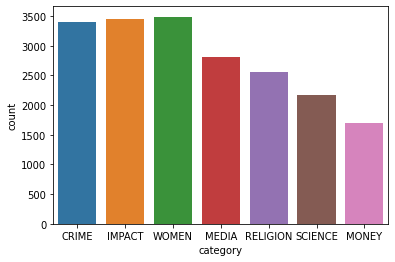

In [16]:
# Check the Distribution of the Dataset

sns.countplot(df2['category']);

In [17]:
# In Topic Modelling, use InterTopic Distance Map (Via Multidimensional Scaling) to Validate
# LDA is based on the Concept of Bag of Words

In [18]:
# Data Cleaning and Preparation

print(df2['short_description'][10])

We may not realize it, but retailers are conditioning us to be our own cashiers.


In [19]:
print(df2['headline'])

0        There Were 2 Mass Shootings In Texas Last Week...
1        With Its Way Of Life At Risk, This Remote Oyst...
2        Rachel Dolezal Faces Felony Charges For Welfar...
3        Morgan Freeman Dropped From Marketing Campaign...
4        Man Faces Charges After Pulling Knife, Stun Gu...
                               ...                        
19605    Thomas Edison Voted Most Iconic Inventor In U....
19606    Aurora Borealis Caused By Huge Solar Storm Shi...
19607                          Tinker and Change the World
19608            Pregnant and Displaced: Double the Danger
19609    Tom Brady Helps Mentor, Tom Martinez, Find A K...
Name: headline, Length: 19610, dtype: object


In [20]:
# Create a Context Columns

df2["context"] = df2["headline"].map(str) + '. ' +df2["short_description"]

In [21]:
# Perform Data Preprocessing
import string

# Remove Punctuations
#df2['headline'] = df2['headline'].map(lambda x: re.sub(string.punctuation, '', x))

# Convert to Lowercase
df2['headline'] = df2['headline'].apply(lambda x: x.lower())

# Validate
df2['headline'].head()

0    there were 2 mass shootings in texas last week...
1    with its way of life at risk, this remote oyst...
2    rachel dolezal faces felony charges for welfar...
3    morgan freeman dropped from marketing campaign...
4    man faces charges after pulling knife, stun gu...
Name: headline, dtype: object

In [22]:
# Create a Translation Table

translation_table = str.maketrans('','',string.punctuation+string.digits)
df2['headline'] = df2['headline'].str.translate(translation_table)

In [25]:
# Validate
df2['headline'].head()

0    there were  mass shootings in texas last week ...
1    with its way of life at risk this remote oyste...
2    rachel dolezal faces felony charges for welfar...
3    morgan freeman dropped from marketing campaign...
4    man faces charges after pulling knife stun gun...
Name: headline, dtype: object

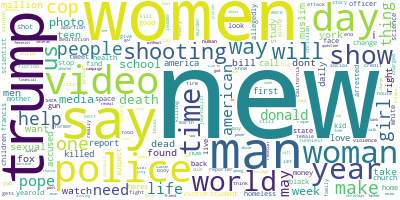

In [27]:
# Explore and Analyse the Data via WordCloud

from wordcloud import WordCloud

# Get top 200 words from the Headline
text = ', '.join(list(df2['headline'].values))

# Generate Wordcloud
wordcloud = WordCloud(background_color= 'white',
                      max_words= 200,
                      contour_width= 3,
                      contour_color= 'steelblue',
                      collocations= False).generate(text)

# Visualize the Sentence
wordcloud.to_image()

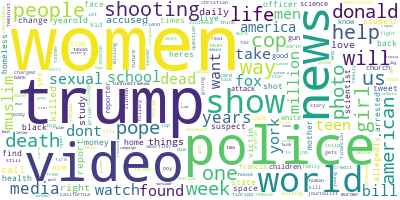

In [30]:
# Remove Custom Stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create Stopword List
stopwords = set(STOPWORDS)
stopwords.update(['time', 'first', 'need', 'thing', 'make', 'new', 'say', 'day', 'woman', 'year','says','man','may'])

# Create Updated Wordcloud

wordcloud_2 = WordCloud(stopwords= stopwords,
                        background_color= 'white',
                        max_words= 200,
                        contour_width= 3,
                        contour_color= 'steelblue',
                        collocations= False).generate(text)

# Visualize the WordCloud
wordcloud_2.to_image()

In [34]:
# Building the Corpus for Topic Modelling

import gensim
from gensim.utils import simple_preprocess

# Split Sentences to Words
def sent_to_words(sentences):
    for sent in sentences:
        yield(simple_preprocess(str(sent), deacc= True))
    return

# Validate the Function
data = df2.headline.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:2])

[['there', 'were', 'mass', 'shootings', 'in', 'texas', 'last', 'week', 'but', 'only', 'on', 'tv'], ['with', 'its', 'way', 'of', 'life', 'at', 'risk', 'this', 'remote', 'oystergrowing', 'region', 'called', 'in', 'robots']]


In [35]:
# Build the N-Grams - Higher Threshold Fewer Phrases
bigram = gensim.models.Phrases(sentences= data_words, min_count= 5, threshold= 100)
trigram = gensim.models.Phrases(sentences= bigram[data_words], threshold= 100)

# Faster way to get sentences tagged as Bigrams and Trigrams
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [38]:
# Removing the Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
stopwords.extend(['time', 'first', 'need', 'thing', 'make', 'new', 'say', 'day', 'woman', 'year','says','man','may'])

# Defining the Function for Stopwords, Bigrams, Trigrams and Lemmatisation

def remove_stopwords(text):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in text]

def make_bigrams(text):
    return [bigram_mod[doc] for doc in text]

def make_trigrams(text):
    return [trigram_mod[bigram_mod[doc]] for doc in text]

def lemmatisation(text, allowed_postags= ['NOUN', 'ADJ', 'VERB', 'ADV']):
    text_out = []
    for sent in text:
        doc = nlp(' '.join(sent))
        text_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return text_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# Lemmatizing the Words - Converting word to its Root word

import spacy

# Removing Stopwords
data_word_nostop = remove_stopwords(data_words)

# Build Bigrams
data_word_bigram = make_bigrams(data_word_nostop)

# Initialize Spacy and keep only tagger component for Efficiency
nlp = spacy.load('en_core_web_sm', disable= ['parser', 'ner'])

# Lemmatize, Keeping only Noun, Adjective, Verb and Adverb
data_lemmatized = lemmatisation(text= data_word_bigram, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Valdiate
print(data_lemmatized[:2])

[['last', 'week', 'tv'], ['way', 'life', 'risk', 'remote', 'oystergrowing', 'region', 'call', 'robot']]


In [40]:
# Building the Corpa

import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Building Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Validate
print(corpus[:2])

[[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]


In [41]:
# Build the Topic Model

# LDA Model
num_topics = 7

lda_model = gensim.models.ldamodel.LdaModel(corpus= corpus,
                                            id2word= id2word,
                                            num_topics= num_topics,
                                            random_state= 42,
                                            chunksize= 100, # Denotes the No of Document in Each Training Set
                                            passes= 10,
                                            # Alpha and Eta are Hyperparameter to represent the Document Topic Density and Word Topic Density
                                            alpha= 0.01,
                                            eta= 'auto',
                                            iterations= 500,
                                            per_word_topics= True) 

In [42]:
# Validate and Visualize the Topics
from pprint import pprint

# Show Keywords from 10 Topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.038*"pay" + 0.024*"give" + 0.023*"know" + 0.023*"thing" + 0.023*"could" + '
  '0.018*"allegedly" + 0.018*"business" + 0.017*"go" + 0.015*"charge" + '
  '0.015*"donation"'),
 (1,
  '0.023*"cause" + 0.020*"right" + 0.019*"bad" + 0.018*"take" + 0.016*"solar" '
  '+ 0.014*"high" + 0.014*"city" + 0.014*"offer" + 0.014*"russian" + '
  '0.014*"avoid"'),
 (2,
  '0.058*"get" + 0.056*"find" + 0.021*"catch" + 0.019*"college" + 0.019*"want" '
  '+ 0.018*"vote" + 0.017*"double" + 0.017*"international" + 0.016*"face" + '
  '0.014*"sex"'),
 (3,
  '0.059*"help" + 0.054*"tax" + 0.042*"financial" + 0.027*"bank" + '
  '0.021*"child" + 0.020*"study" + 0.019*"people" + 0.018*"history" + '
  '0.016*"scientist" + 0.016*"plan"'),
 (4,
  '0.070*"video" + 0.036*"way" + 0.027*"change" + 0.024*"debt" + 0.023*"life" '
  '+ 0.020*"home" + 0.018*"credit" + 0.017*"year" + 0.016*"return" + '
  '0.015*"yearold"'),
 (5,
  '0.050*"money" + 0.047*"photo" + 0.033*"world" + 0.024*"cost" + 0.022*"save" '
  '+ 0.021

In [45]:
# Not all topics are Semantically Coherant, and Affects quality of the Model. So we test for Interpretablity and Goodness of the Model

# Estimating Goodness of a Topic Model
from gensim.models import CoherenceModel

# Compute Perplexity - Measure of How good the Model is. Lower is better
print("\nPerplexity: ", lda_model.log_perplexity(corpus))

# Coherence Score - Assigns Score to a Topic by measuring the Degree of Semantic Similarity between most frequent words in a Topic
coherence_model_lda = CoherenceModel(model= lda_model, texts= data_lemmatized, dictionary= id2word, coherence= 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score - CV: ', coherence_lda)

# Compute Coherence_Score using UMass
coherence_model_lda = CoherenceModel(model= lda_model, texts= data_lemmatized, dictionary= id2word, coherence= 'u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score - UMass: ', coherence_lda)


Perplexity:  -38.98500069382318

Coherence Score - CV:  0.566666352154691

Coherence Score - UMass:  -14.56306965610288


In [46]:
# Visualizing the Model

!pip install -U pyLDAvis

import pyLDAvis.gensim

     |████████████████████████████████| 1.6MB 4.6MB/s 
     |████████████████████████████████| 552kB 30.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=edef7bc54c6c118e52a962ced5a189c32ff14073d835112dc8618842e12d17e6
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=e109e90c60c1a7c7d881cd34163434b6e3b52973ac143852c74739628edf15a4
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [47]:
# Visualize

# Enable Notebook
pyLDAvis.enable_notebook()

# Plot
vis = pyLDAvis.gensim.prepare(topic_model= lda_model, corpus= corpus, dictionary= id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.321089  0.222783       1        1  15.547877
0     -0.147149 -0.054952       2        1  15.018277
1     -0.093097  0.165208       3        1  14.316015
3      0.203192 -0.167038       4        1  14.154291
4     -0.163260  0.121093       5        1  13.735329
2     -0.143068  0.024967       6        1  13.725753
6      0.022293 -0.312061       7        1  13.502458, topic_info=               Term        Freq       Total Category  logprob  loglift
119           video  799.000000  799.000000  Default  30.0000  30.0000
480            help  695.000000  695.000000  Default  29.0000  29.0000
161             get  659.000000  659.000000  Default  28.0000  28.0000
272            find  638.000000  638.000000  Default  27.0000  27.0000
1949            tax  634.000000  634.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
37            watch   96.755814   97.076683   Topic7  -4.7550   1.9990
5412            owe   74.717575   74.971359   Topic7  -5.0134   1.9989
6979  study_suggest   77.092026   77.358017   Topic7  -4.9822   1.9989
1036     government   82.236984   82.527840   Topic7  -4.9176   1.9988
716            sell   82.587624   82.885277   Topic7  -4.9133   1.9987

[250 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1208      7  0.998476    account
2826      6  1.000324     affect
1448      2  0.999927  allegedly
573       4  0.994804     arrest
987       5  0.994559        ask
...     ...       ...        ...
91        1  0.999273      world
365       7  0.995600      would
510       5  0.999513       year
979       5  0.997610    yearold
299       5  0.993787      young

[226 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 4, 5, 3, 7])